In [1]:
import numpy as np
import torch, sys
from torchvision.transforms import functional as func
import torchvision.transforms as transforms
from loss import ComputeLoss
import yaml, random
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
from new_model import Model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
from torch.utils.data import DataLoader

from dataloader import FiftyOneTorchDataset
from util import non_max_suppression


In [2]:
dataset_train = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    # label_types=[""],
    classes=["cat", "dog"],
    max_samples=128,
)

Found annotations at 'C:\Users\kevin\fiftyone\coco-2017\raw\instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-128'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:

dataset_validation = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    # label_types=[""],
    classes=["cat", "dog"],
    max_samples=64,
)

Found annotations at 'C:\Users\kevin\fiftyone\coco-2017\raw\instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-64'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:

dataset_train.persistent = True
dataset_validation.persistent = True
view_train = dataset_train.filter_labels("ground_truth", F("label").is_in(("cat", "dog")))
view_val = dataset_validation.filter_labels("ground_truth", F("label").is_in(("cat", "dog")))
view_train = view_train.take(128, seed=63)
view_val = view_val.take(64, seed=63)

fil_classes = ["cat", "dog"]
device = torch.device('cuda:0')

with open("hyp.yaml", "r") as stream:
    try:
        hyp = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


org_w = 640
org_h = 480
scaling_factor = 640/480

batch_size = 8

transform = transforms.Compose([transforms.Resize((int(org_h/scaling_factor), int(org_w/scaling_factor))),
                                transforms.Pad((0, int((org_w - org_h)/(2*scaling_factor)),0,int((org_w - org_h)/(2*scaling_factor)))),
                                transforms.ToTensor()])
            
dataset_train = FiftyOneTorchDataset(view_train, transform, classes=fil_classes)
dataset_val = FiftyOneTorchDataset(view_val, transform, classes=fil_classes)
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True)



In [ ]:

model = Model('yolov3.cfg', hyp=hyp).to(device)

optimizer = torch.optim.Adam(model.parameters(),1e-3)
loss_fcn = ComputeLoss(model)
#training
train_loss_list = []
val_loss_list = []
# Add predictions to samples\
epochs = 10
for epoch in range(epochs):
    #training
    tot_loss = 0
    count = 0
    for images, targets in loader_train:
        model.train()
        images = images.to(device)
        targets = targets.to(device)
        preds = model(images)
        loss, loss_parts = loss_fcn(preds, targets)
        tot_loss += loss / batch_size
        count += 1
        loss.backward()
        optimizer.step()
        
    #save the model each 50 epochs
    if epoch%5==0 and epoch!=0:
        torch.save(model,'./models/model'+str(epoch)+'.pt')
    print('training',epoch, tot_loss.item()/count)
    train_loss_list.append(tot_loss.item()/count)
    
    #validation
    tot_loss = 0
    count = 0
    for images, targets in loader_val:
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            preds = model(images)
        loss, loss_parts = loss_fcn(preds, targets)
        tot_loss += loss / batch_size
        count += 1
    print('validation',epoch, tot_loss.item()/count)
    val_loss_list.append(tot_loss.item()/count)

torch.save(model,'./models/final'+'.pt')    


#  TODO: val code, val dataloader, save model, save training loss



In [ ]:
from util import plot
plot(train_loss_list[:],val_loss_list,'train loss','val loss','loss','train loss and validation loss')

In [5]:
from util import my_img_plot
import gc
gc.collect() 
torch.cuda.empty_cache()
device = torch.device('cuda:0')
model = torch.load('./models/final.pt').to(device)




2
torch.Size([8, 14175, 7])
torch.Size([3, 480, 480])


<Figure size 432x288 with 0 Axes>

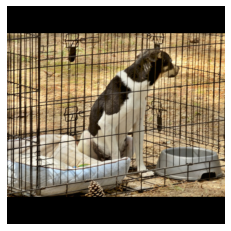

2
torch.Size([8, 14175, 7])
torch.Size([3, 480, 480])


<Figure size 432x288 with 0 Axes>

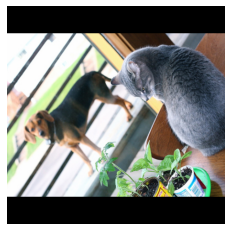

2
torch.Size([8, 14175, 7])
torch.Size([3, 480, 480])


<Figure size 432x288 with 0 Axes>

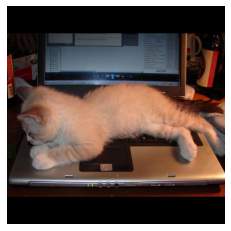

2
torch.Size([8, 14175, 7])
torch.Size([3, 480, 480])


<Figure size 432x288 with 0 Axes>

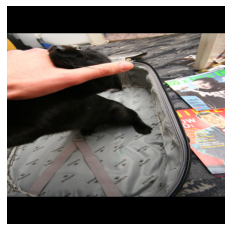

2
torch.Size([8, 14175, 7])
torch.Size([3, 480, 480])


<Figure size 432x288 with 0 Axes>

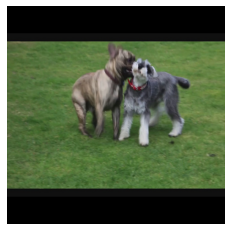

2
torch.Size([8, 14175, 7])
torch.Size([3, 480, 480])


<Figure size 432x288 with 0 Axes>

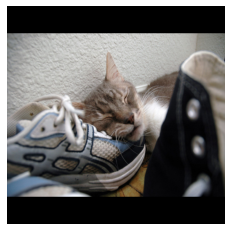

2
torch.Size([8, 14175, 7])
torch.Size([3, 480, 480])


<Figure size 432x288 with 0 Axes>

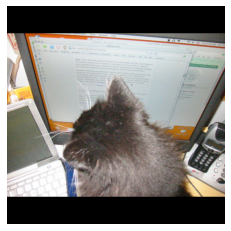

2
torch.Size([8, 14175, 7])
torch.Size([3, 480, 480])


<Figure size 432x288 with 0 Axes>

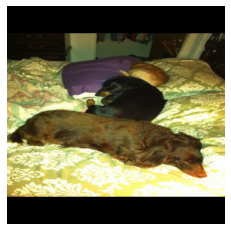

In [11]:

model.eval()
for images, targets in loader_val:
    # for image in images:
    images = images.to(device)
    with torch.no_grad():
        pred = model(images)
        print(len(pred))
        print(pred[0].shape)
        print(images[0].shape)
        my_img_plot(pred[0],images[0],fil_classes,1)
    # break